# Latent Semantic Indexing

Here, we apply the technique *Latent Semantic Indexing* to capture the similarity of words. We are given a list of words and their frequencies in 9 documents, found on [GitHub](https://github.com/ppham27/MLaPP-solutions/blob/master/chap12/lsiDocuments.pdf).

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing

plt.rcParams['font.size'] = 16

words_list = list()
with open('lsiWords.txt') as f:
    for line in f:
        words_list.append(line.strip())
words = pd.Series(words_list, name="words")
word_frequencies = pd.read_csv('lsiMatrix.txt', sep=' ', index_col=False,
                               header=None, names=words)
word_frequencies.T.head(20)

,0,1,2,3,4,5,6,7,8
000,2,0,4,0,0,0,0,0,0
100,0,0,2,0,0,0,0,0,0
1913,0,0,0,3,0,0,0,0,0
1977,0,0,0,0,0,0,2,0,0
2001,0,0,0,0,0,0,0,2,0
4,0,0,2,0,0,0,0,0,0
5,0,0,2,0,0,0,0,0,0
500,2,0,0,0,0,0,0,0,0
"""",0,27,13,23,19,48,56,35,22
(,4,2,3,7,4,0,5,8,4


Now as per part (a), we compute the SVD and use the first two singular values. Recall the model is that

\begin{equation}
\mathbf{x} \sim \mathcal{N}\left(W\mathbf{z},\Psi\right),
\end{equation}

where $\Psi$ is diagonal. If the SVD is $X = UDV^\intercal,$ $W$ will be the first two columns of $V$.

In [2]:
X = word_frequencies.as_matrix().astype(np.float64)
U, D, V = np.linalg.svd(X.T)  # in matlab the matrix is read in as its transpose

In this way, we let $Z = UD$, so $X = ZV^\intercal$. Now, let $\tilde{Z}$ be the approximation from using 2 singular values, so $\tilde{X} = \tilde{Z}W^\intercal$, so $\tilde{Z} = \tilde{U}\tilde{D}$. For some reason, the textbook chooses not to scale by $\tilde{D}$, so we just have $\tilde{U}$. Recall that all the variables are messed up because we used the tranpose.

In [3]:
Z = V.T[:,:2]
Z

array([[-0.29579069, -0.51925267],
       [-0.3133317 , -0.33578154],
       [-0.27364718, -0.45865789],
       [-0.34873574,  0.47093077],
       [-0.22977276,  0.04358919],
       [-0.44143778,  0.28243982],
       [-0.3498604 ,  0.22347862],
       [-0.35250449,  0.17379354],
       [-0.35143587, -0.1538357 ]])

Now, let's plot these results.

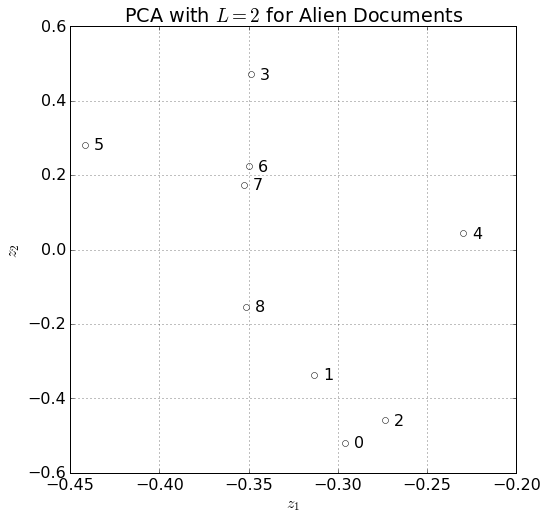

In [4]:
plt.figure(figsize=(8,8))
def plot_latent_variables(Z, ax=None):
    if ax == None:
        ax = plt.gca()
    ax.plot(Z[:,0], Z[:,1], 'o', markerfacecolor='none')
    for i in range(len(Z)):
        ax.text(Z[i,0] + 0.005, Z[i,1], i, 
                verticalalignment='center')
    ax.set_xlabel('$z_1$')
    ax.set_ylabel('$z_2$')
    ax.set_title('PCA with $L = 2$ for Alien Documents')
    ax.grid(True)
plot_latent_variables(Z)
plt.show()

I, respectfully, disagree with the book for this reason. The optimal latent representation $Z = XW$ (observations are rows here), should be chosen such that

\begin{equation}
J(W,Z) = \frac{1}{N}\left\lVert X - ZW^\intercal\right\rVert^2
\end{equation}

is minimized, where $W$ is orthonormal.

In [5]:
U, D, V = np.linalg.svd(X)
V = V.T # python implementation of SVD factors X = UDV (note that V is not tranposed)

By section 12.2.3 of the book, $W$ is the first $2$ columns of $V$. Thus, our actual plot should be below.

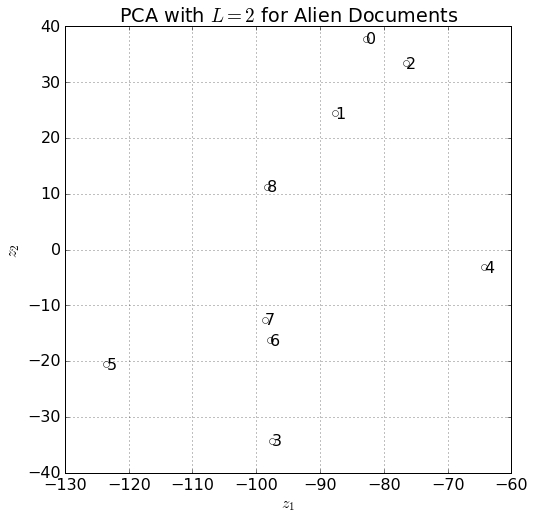

In [6]:
W = V[:,:2]
Z = np.dot(X, W)
plt.figure(figsize=(8,8))
plot_latent_variables(Z)
plt.show()

Note that this is very similar with the $y$-axis flipped. That part does not actually matter. What matters is the scaling by eigenvalues for computing. Before that scaling the proximity of points may not mean much if the eigenvalue is actually very large.

Now, the second part asks us to see if we can properly identify documents related to abductions by using a document with the single word *abducted* as a probe.

In [7]:
probe_document = np.zeros_like(words, dtype=np.float64)
abducted_idx = (words=='abducted').as_matrix()
probe_document[abducted_idx] = 1
X[0:3,abducted_idx]

array([[ 0.],
       [ 6.],
       [ 3.]])

Note that despite the first document being about abductions, it doesn't contain the word *abducted*.

Let's look at the latent variable representation. We'll use cosine similarity to account for the difference in magnitude.

In [8]:
from scipy.spatial import distance
z = np.dot(probe_document, W)
similarities = list(map(lambda i : (i, 1 - distance.cosine(z,Z[i,:])), range(len(Z))))
similarities.sort(key=lambda similarity_tuple : -similarity_tuple[1])
similarities

[(0, 0.59127529086736064),
 (2, 0.57730256865377172),
 (1, 0.45835648369851389),
 (8, 0.31235652085315346),
 (4, 0.15438034299529768),
 (7, 0.076686002588720159),
 (6, 0.039651047230294334),
 (5, 0.039384780001176511),
 (3, -0.13308361596893792)]

Indeed, we find the three alien abduction documents, $0$, $2$, and $1$ are most similar to our probe.